# 01b: Single-Layer Spiking NN (MNIST)

This notebook demonstrates a minimal single-layer spiking neural network (SNN) trained from scratch using only NumPy and the repo's `MNISTDataProvider`.

- Encoding: Poisson spike trains from pixel intensities.
- Neuron: Simple LIF-like integration with soft reset.
- Learning: Perceptron-style rule on input spike rates.
- Evaluation: Argmax of output spike counts.

This is a didactic example focused on clarity, not performance.

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Local package
import mlp.data_providers as data_providers

# Ensure MLP_DATA_DIR is set by walking up to find the repo's data/ folder
def ensure_mlp_data_dir():
    if os.environ.get('MLP_DATA_DIR'):
        return Path(os.environ['MLP_DATA_DIR'])
    here = Path.cwd().resolve()
    for p in [here] + list(here.parents):
        candidate = p / 'data'
        if (candidate / 'mnist-train.npz').exists():
            os.environ['MLP_DATA_DIR'] = str(candidate)
            return candidate
    raise RuntimeError('Could not locate data directory with mnist-*.npz')

data_dir = ensure_mlp_data_dir()
print('Using data dir:', data_dir)

Using data dir: /Users/ewkoch/repos/mlpractical/data


In [3]:
# Create training/validation providers
train_dp = data_providers.MNISTDataProvider('train', batch_size=64, max_num_batches=100, shuffle_order=True)
valid_dp = data_providers.MNISTDataProvider('valid', batch_size=64, max_num_batches=50, shuffle_order=False)
print('Batches per epoch (train, valid):', train_dp.len(), valid_dp.len())

Batches per epoch (train, valid): 100 50


In [4]:
# Utilities: scaling and Poisson encoding
def scale01(x: np.ndarray) -> np.ndarray:
    # MNIST may already be in [0,1], but guard just in case
    xmax = np.max(x)
    if xmax > 1.5:
        return (x / 255.0).astype(np.float32)
    return x.astype(np.float32)

def poisson_encode(inputs: np.ndarray, T: int, rate_hz: float = 30.0, dt: float = 0.005, rng: np.random.RandomState | None = None) -> np.ndarray:
    """Encode inputs in [0,1] into Poisson spikes over T steps.
    inputs: (B, D) in [0,1]
    returns: spikes (B, T, D) with 0/1 values
    """
    if rng is None:
        rng = np.random.RandomState(0)
    B, D = inputs.shape
    lam = np.clip(inputs, 0.0, 1.0) * rate_hz * dt  # probability per bin
    # Sample T independent Bernoulli trials per feature
    spikes = rng.rand(B, T, D) < lam[:, None, :]
    return spikes.astype(np.float32)

# Quick sanity on encoder
xb, yb = next(iter(train_dp))
xb = scale01(xb)
sp = poisson_encode(xb[:2], T=10)
print('Example spikes shape:', sp.shape, 'spike fraction:', sp.mean())

Example spikes shape: (2, 10, 784) spike fraction: 0.023086734


In [5]:
# Single-layer SNN with LIF-like integration and soft reset
class SingleLayerSNN:
    def __init__(self, input_dim: int, num_classes: int, dt: float = 0.005, tau: float = 0.02, vth: float = 1.0, seed: int = 0):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.dt = dt
        self.tau = tau
        self.vth = vth
        self.alpha = float(np.exp(-dt / tau))
        rng = np.random.RandomState(seed)
        # Small random weights
        self.W = 0.01 * rng.randn(input_dim, num_classes).astype(np.float32)

    def forward_counts(self, spikes: np.ndarray) -> np.ndarray:
        """spikes: (B, T, D) -> counts: (B, C)
        Integrate inputs, emit spikes when v >= vth, soft reset.
        """
        B, T, D = spikes.shape
        assert D == self.input_dim
        v = np.zeros((B, self.num_classes), dtype=np.float32)
        counts = np.zeros_like(v)
        for t in range(T):
            xt = spikes[:, t, :]  # (B, D)
            I = xt @ self.W       # (B, C)
            v = self.alpha * v + I
            fired = v >= self.vth
            counts += fired.astype(np.float32)
            # soft reset: subtract threshold where fired
            v = np.where(fired, v - self.vth, v)
        return counts

    def predict(self, spikes: np.ndarray) -> np.ndarray:
        counts = self.forward_counts(spikes)
        return counts.argmax(axis=1)

    def train_step(self, spikes: np.ndarray, y_int: np.ndarray, lr: float = 0.05) -> int:
        """Perceptron-like update on input spike rates.
        Only misclassified samples contribute: +x_rate to true class, -x_rate to predicted.
        """
        B = spikes.shape[0]
        preds = self.predict(spikes)
        mis = preds != y_int
        if not np.any(mis):
            return 0
        # Use average input spike rate as a proxy feature
        x_rate = spikes.mean(axis=1)  # (B, D)
        E = np.zeros((B, self.num_classes), dtype=np.float32)
        # For misclassified, increment true class, decrement predicted
        E[np.arange(B)[mis], y_int[mis]] += 1.0
        E[np.arange(B)[mis], preds[mis]] -= 1.0
        dW = x_rate.T @ E  # (D, C)
        self.W += (lr / B) * dW
        return int(mis.sum())


In [8]:
# Train the SNN on a subset for speed
input_dim = 28*28
num_classes = 10
snn = SingleLayerSNN(input_dim, num_classes, dt=0.005, tau=0.02, vth=1.0, seed=1)

epochs = 50
T = 20
lr = 0.05
rng = np.random.RandomState(123)

for ep in range(1, epochs+1):
    total, wrong = 0, 0
    for xb, yb in train_dp:
        xb = scale01(xb)
        y_int = yb.argmax(axis=1).astype(int)
        spikes = poisson_encode(xb, T=T, rate_hz=30.0, dt=snn.dt, rng=rng)
        wrong += snn.train_step(spikes, y_int, lr=lr)
        total += xb.shape[0]
    train_acc = 1.0 - wrong / max(1, total)
    # Evaluate
    correct_v, total_v = 0, 0
    for xb, yb in valid_dp:
        xb = scale01(xb)
        y_int = yb.argmax(axis=1).astype(int)
        spikes = poisson_encode(xb, T=T, rate_hz=30.0, dt=snn.dt, rng=rng)
        preds = snn.predict(spikes)
        correct_v += int((preds == y_int).sum())
        total_v += xb.shape[0]
    valid_acc = correct_v / max(1, total_v)
    print(f'Epoch {ep}: train_acc={train_acc:.3f} valid_acc={valid_acc:.3f}')

Epoch 1: train_acc=0.298 valid_acc=0.524
Epoch 2: train_acc=0.551 valid_acc=0.618
Epoch 3: train_acc=0.634 valid_acc=0.669
Epoch 4: train_acc=0.663 valid_acc=0.695
Epoch 5: train_acc=0.699 valid_acc=0.721
Epoch 6: train_acc=0.707 valid_acc=0.729
Epoch 7: train_acc=0.723 valid_acc=0.734
Epoch 8: train_acc=0.739 valid_acc=0.743
Epoch 9: train_acc=0.742 valid_acc=0.759
Epoch 10: train_acc=0.743 valid_acc=0.756
Epoch 11: train_acc=0.756 valid_acc=0.754
Epoch 12: train_acc=0.762 valid_acc=0.767
Epoch 13: train_acc=0.767 valid_acc=0.774
Epoch 14: train_acc=0.778 valid_acc=0.784
Epoch 15: train_acc=0.775 valid_acc=0.785
Epoch 16: train_acc=0.770 valid_acc=0.781
Epoch 17: train_acc=0.778 valid_acc=0.796
Epoch 18: train_acc=0.790 valid_acc=0.782
Epoch 19: train_acc=0.791 valid_acc=0.786
Epoch 20: train_acc=0.783 valid_acc=0.793
Epoch 21: train_acc=0.795 valid_acc=0.783
Epoch 22: train_acc=0.791 valid_acc=0.797
Epoch 23: train_acc=0.792 valid_acc=0.802
Epoch 24: train_acc=0.800 valid_acc=0.793
E

True label: 3 Predicted: 3


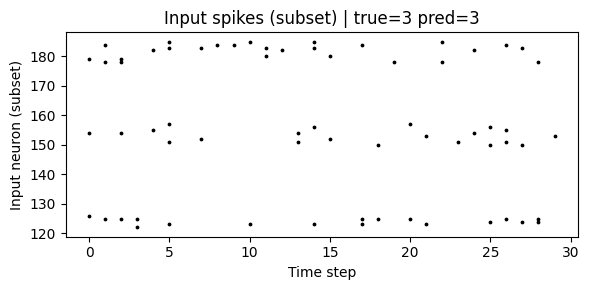

In [9]:
# Visualize spikes for a single example
xb, yb = next(iter(valid_dp))
xb = scale01(xb)
label = int(yb[0].argmax())
sp = poisson_encode(xb[:1], T=30, rate_hz=30.0, dt=snn.dt, rng=np.random.RandomState(0))  # (1, T, D)
pred = int(snn.predict(sp)[0])
print('True label:', label, 'Predicted:', pred)

plt.figure(figsize=(6, 3))
# Raster: plot spikes for first 200 input channels to keep it readable
subset = 200
sp_idx, t_idx = np.where(sp[0, :, :subset].T > 0)  # (neuron, time) pairs
plt.scatter(t_idx, sp_idx, s=3, c='black')
plt.xlabel('Time step')
plt.ylabel('Input neuron (subset)')
plt.title(f'Input spikes (subset) | true={label} pred={pred}')
plt.tight_layout()
plt.show()